In [1]:
import random
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import requests
import tqdm
import matplotlib.pyplot as plt

Function to get the Sherlock Holmes data.

In [2]:
def fetch_data(get_n_files=10):
    """Data taken from : "https://github.com/brilliantorg/sherlock/tree/master"
    """
    base_url = "https://raw.githubusercontent.com/brilliantorg/sherlock/refs/heads/master/stories"
    file_names = [
        "003_ASH_01_Scandal_In_Bohemia.txt",
        "004_ASH_02_Red_Headed_League.txt",
        "005_ASH_03_Case_Of_Identity.txt",
        "006_ASH_04_Boscombe_Valley_Mystery.txt",
        "007_ASH_05_Five_Orange_Pips.txt",
        "008_ASH_06_Man_With_Twisted_Lip.txt",
        "009_ASH_07_Blue_Carbuncle.txt",
        "010_ASH_08_Speckled_Band.txt",
        "011_ASH_09_Engineers_Thumb.txt",
        "012_ASH_10_Noble_Bachelor.txt",
        "013_ASH_11_Beryl_Coronet.txt",
        "014_ASH_12_Copper_Beeches.txt",
        "015_MSH_01_Silver_Blaze.txt",
        "016_MSH_02_Cardboard_Box.txt",
        "017_MSH_03_Yellow_Face.txt",
        "018_MSH_04_Stockbrokers_Clerk.txt",
        "019_MSH_05_Gloria_Scott.txt",
        "020_MSH_06_Musgrave_Ritual.txt",
        "021_MSH_07_Reigate_Squire.txt",
        "022_MSH_08_Crooked_Man.txt",
        "023_MSH_09_Resident_Patient.txt",
        "024_MSH_10_Greek_Interpreter.txt",
        "025_MSH_11_Naval_Treaty.txt",
        "026_MSH_12_Final_Problem.txt",
        "029_RSH_01_Empty_House.txt",
        "030_RSH_02_Norwood_Builder.txt",
        "031_RSH_03_Dancing_Men.txt",
        "032_RSH_04_Solitary_Cyclist.txt",
        "033_RSH_05_Priory_School.txt",
        "034_RSH_06_Black_Peter.txt",
        "035_RSH_07_Charles_Augustus_Milverton.txt",
        "036_RSH_08_Six_Napoleons.txt",
        "037_RSH_09_Three_Students.txt",
        "038_RSH_10_Golden_PinceNez.txt",
        "039_RSH_11_Missing_Three_Quarter.txt",
        "040_RSH_12_Abbey_Grange.txt",
        "041_RSH_13_Second_Stain.txt",
        "042_HLB_1_Wisteria_Lodge_MULTIPART.txt",
        "043_HLB_2_Bruce_Partington_Plans.txt",
        "044_HLB_3_Devil's_Foot.txt",
        "045_HLB_4_Red_Circle.txt",
        "046_HLB_5_Disappearance_Lady_Frances_Carfax.txt",
        "047_HLB_6_Dying_Detective.txt",
        "049_HLB_7_His_Last_Bow.txt",
        "050_CBSH_1_Mazarin_Stone.txt",
        "051_CBSH_2_Thor_Bridge.txt",
        "052_CBSH_3_Creeping_Man.txt"
    ]
    text_list = []
    for file_name in tqdm.tqdm(file_names[:get_n_files]):
        url = f"{base_url}/{file_name}"
        response = requests.get(url)
        text = response.text
        text_list.append(text)
    return text_list

Create the Markov Model for generating text.

In [3]:
class MarkovModel:
    def __init__(self, n_gram=2):
        self.transition_dict = {}
        self.n_gram = n_gram

    def preprocess_text(self, text_list):
        cleaned_texts = []
        for text in text_list:
            text = text.lower()
            text = re.sub(r'[,\"\'!@#$%^&*()_+]', '', text)
            tokens = word_tokenize(text)
            tokens = [token for token in tokens if token.isalpha() or token=="."]
            cleaned_texts.append(tokens)
        return cleaned_texts

    def train_model(self, text_list):
        for text in text_list:
            for i in range(len(text) - self.n_gram - 1):
                current_key = " ".join(text[i:i+self.n_gram])
                next_key = " ".join(text[i+1:i+self.n_gram+1])
                if current_key not in self.transition_dict:
                    self.transition_dict[current_key] = {}
                    self.transition_dict[current_key][next_key] = 1
                else:
                    if next_key in self.transition_dict[current_key]:
                        self.transition_dict[current_key][next_key] += 1
                    else:
                        self.transition_dict[current_key][next_key] = 1
        for current_key in self.transition_dict:
            total_count = sum(self.transition_dict[current_key].values())
            for next_key in self.transition_dict[current_key]:
                self.transition_dict[current_key][next_key] /= total_count
    
    def generate_text(self, start_text, max_words=100, stop_at_punctuation=False):
        output_text = start_text
        current_key = " ".join(word_tokenize(start_text.lower())[-self.n_gram:])
        count = len(word_tokenize(start_text.lower()))
        while count < max_words:
            if current_key not in self.transition_dict:
                break
            next_key = random.choices(list(self.transition_dict[current_key].keys()), weights=list(self.transition_dict[current_key].values()))[0]
            output_text += ' ' + next_key.split(" ")[-1]
            current_key = next_key
            if stop_at_punctuation and current_key.split(" ")[-1]==".":
                break
            count += 1
        return output_text
    
    def plot_next_word_probability(self, start_text):
        current_key = " ".join(word_tokenize(start_text.lower())[-self.n_gram:])
        if current_key not in self.transition_dict:
            print(f"No next words found for given start text '{start_text}'")
            return
        next_words = []
        next_word_probabilities = []
        for next_key in self.transition_dict[current_key]:
            next_words.append(next_key.split(" ")[-1])
            next_word_probabilities.append(self.transition_dict[current_key][next_key])
        plt.figure(figsize=(20, 10))
        plt.bar(next_words, next_word_probabilities)
        plt.xlabel("Next Word")
        plt.title(f"Next Word Probabilities for '{start_text}'")
        plt.ylim(0, 1)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

In [4]:
model = MarkovModel(n_gram=2)

Preprocess the data for the model.

In [5]:
text_list = model.preprocess_text(fetch_data(get_n_files=20))
text_list[0][:10]

100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


['a',
 'scandal',
 'in',
 'bohemia',
 'to',
 'sherlock',
 'holmes',
 'she',
 'is',
 'always']

In [6]:
model.train_model(text_list)

Generate the texts.

In [7]:
print(model.generate_text("a scandal"))

a scandal in bohemia to sherlock holmes one day father struck a gong upon the case has been submitted to us i could learn miss alice wasnt from the . you will play for a row three of them got quite close to me for a few hundred yards from the reigning families of europe . to be . ill tell you that your boots although used are by no means . i am neville clair of lee said my companion who was this dark place and takes the first stage of my cane came home from an envelope and


In [8]:
print(model.generate_text("he heard"))

he heard the sound of voices . ive always been so intimate with miss sarah that he was . but say nothing about hardware . tut you will find little credit to the person or in his eyes . perhaps you would confer a great benefactor to him to remember that fellow will not sleep that night i tossed my rocket into the hands of our friendship defined my limits in a word with us warmly . all well . if he were indeed thinking of turning up in a hurry . and i had let myself go a little


In [9]:
print(model.generate_text("how was", stop_at_punctuation=True))

how was it faded again and remained sitting after you had no time to catch the man who had produced such a cold morning of the deeds of hellish cruelty the hidden wickedness which may be you .


In [10]:
print(model.generate_text("a scandal", max_words=500))

a scandal in the hollow he remarked and yet none of those drunken sallies from which all this you must regret the hour you have also examined every stable and in the direction of criminal research but had refused to deal summarily with the force of many tons upon this metal floor . he stepped up to the many causes célèbres and sensational trials in which i had heard . without a sign that he was about to enter upon a of the united states government and of course said he . i have only just recovered from an afternoon stroll to find the advertisement columns of water . the dog at you . so i smoked a pipe behind him when he learns that his son but i can not see anyone of my father was at its very annoying though watson . but for the fee was at such an absolute imbecile in his eagerness and smoothing it out . musgrave still stood with his brother who usually works with him when he was in hampshire . hell be gone before you reached the corner of the station . sherlock holmes had sent on a ma

Plot probability for each start text.

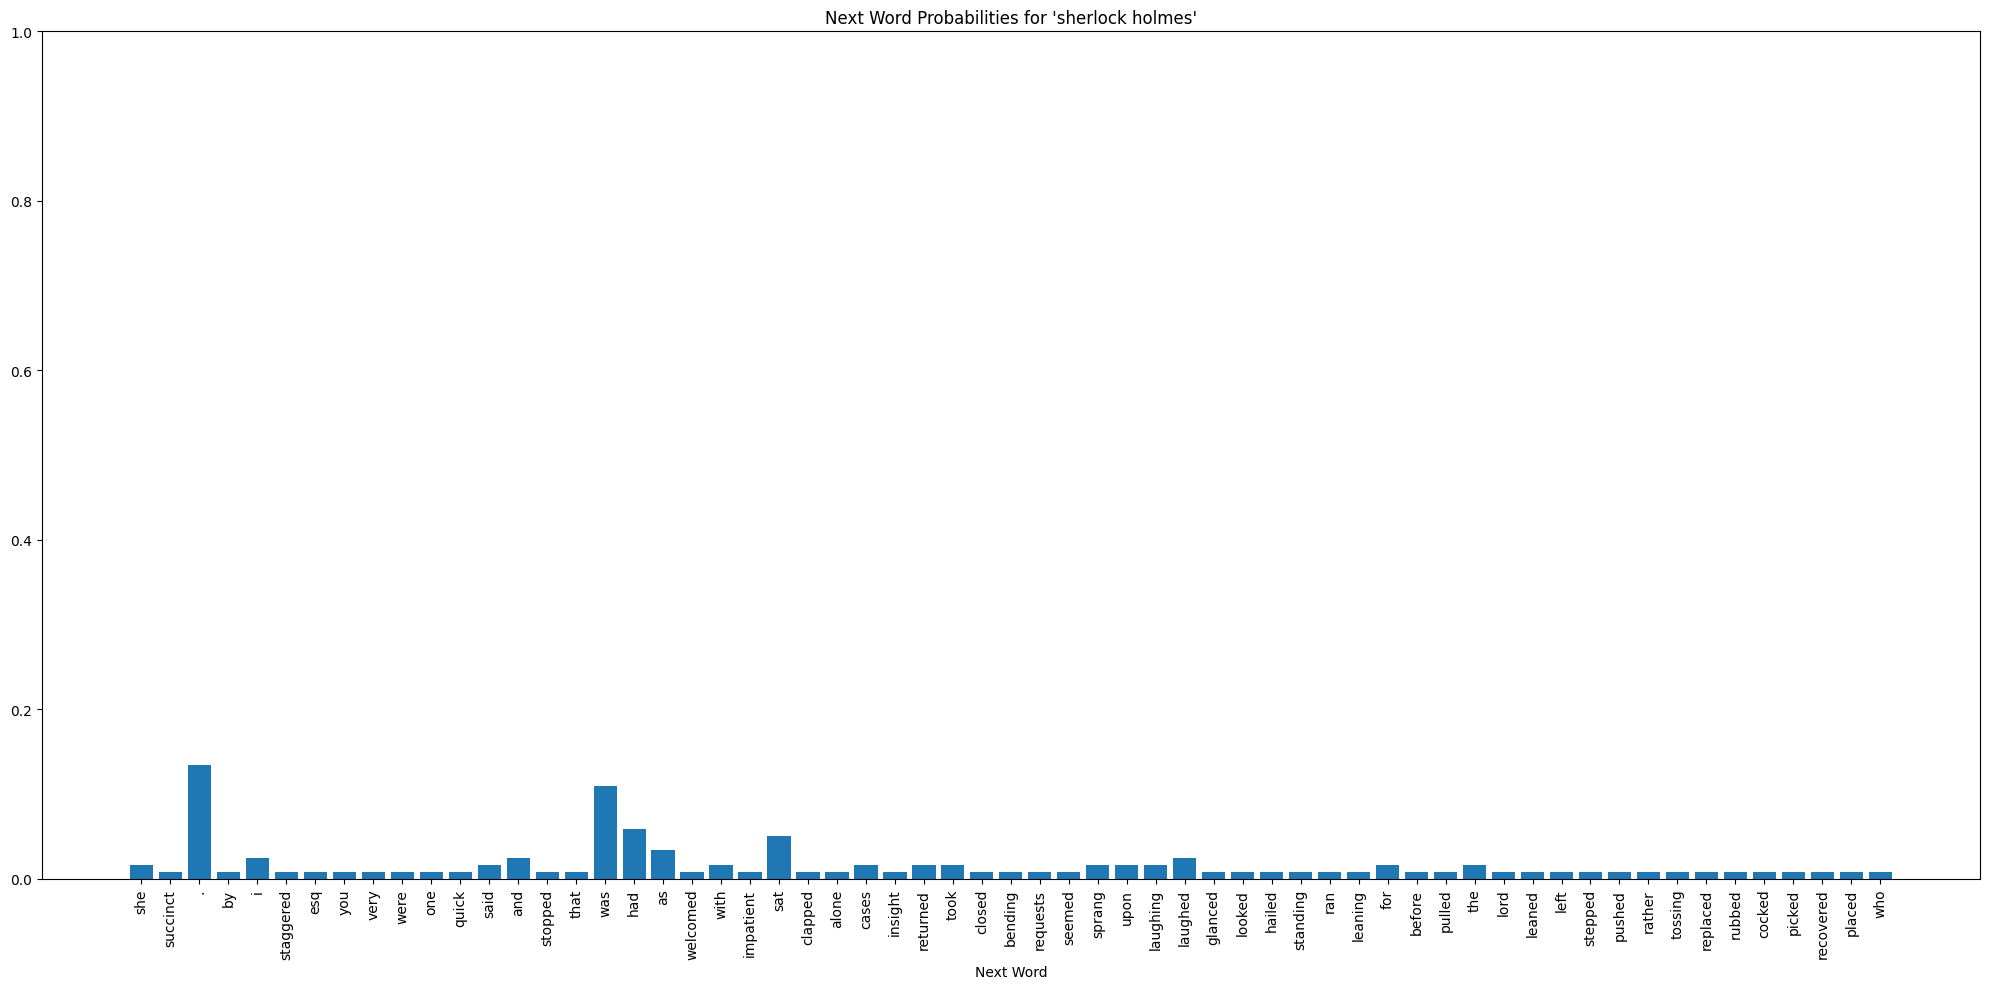

In [11]:
model.plot_next_word_probability("sherlock holmes")

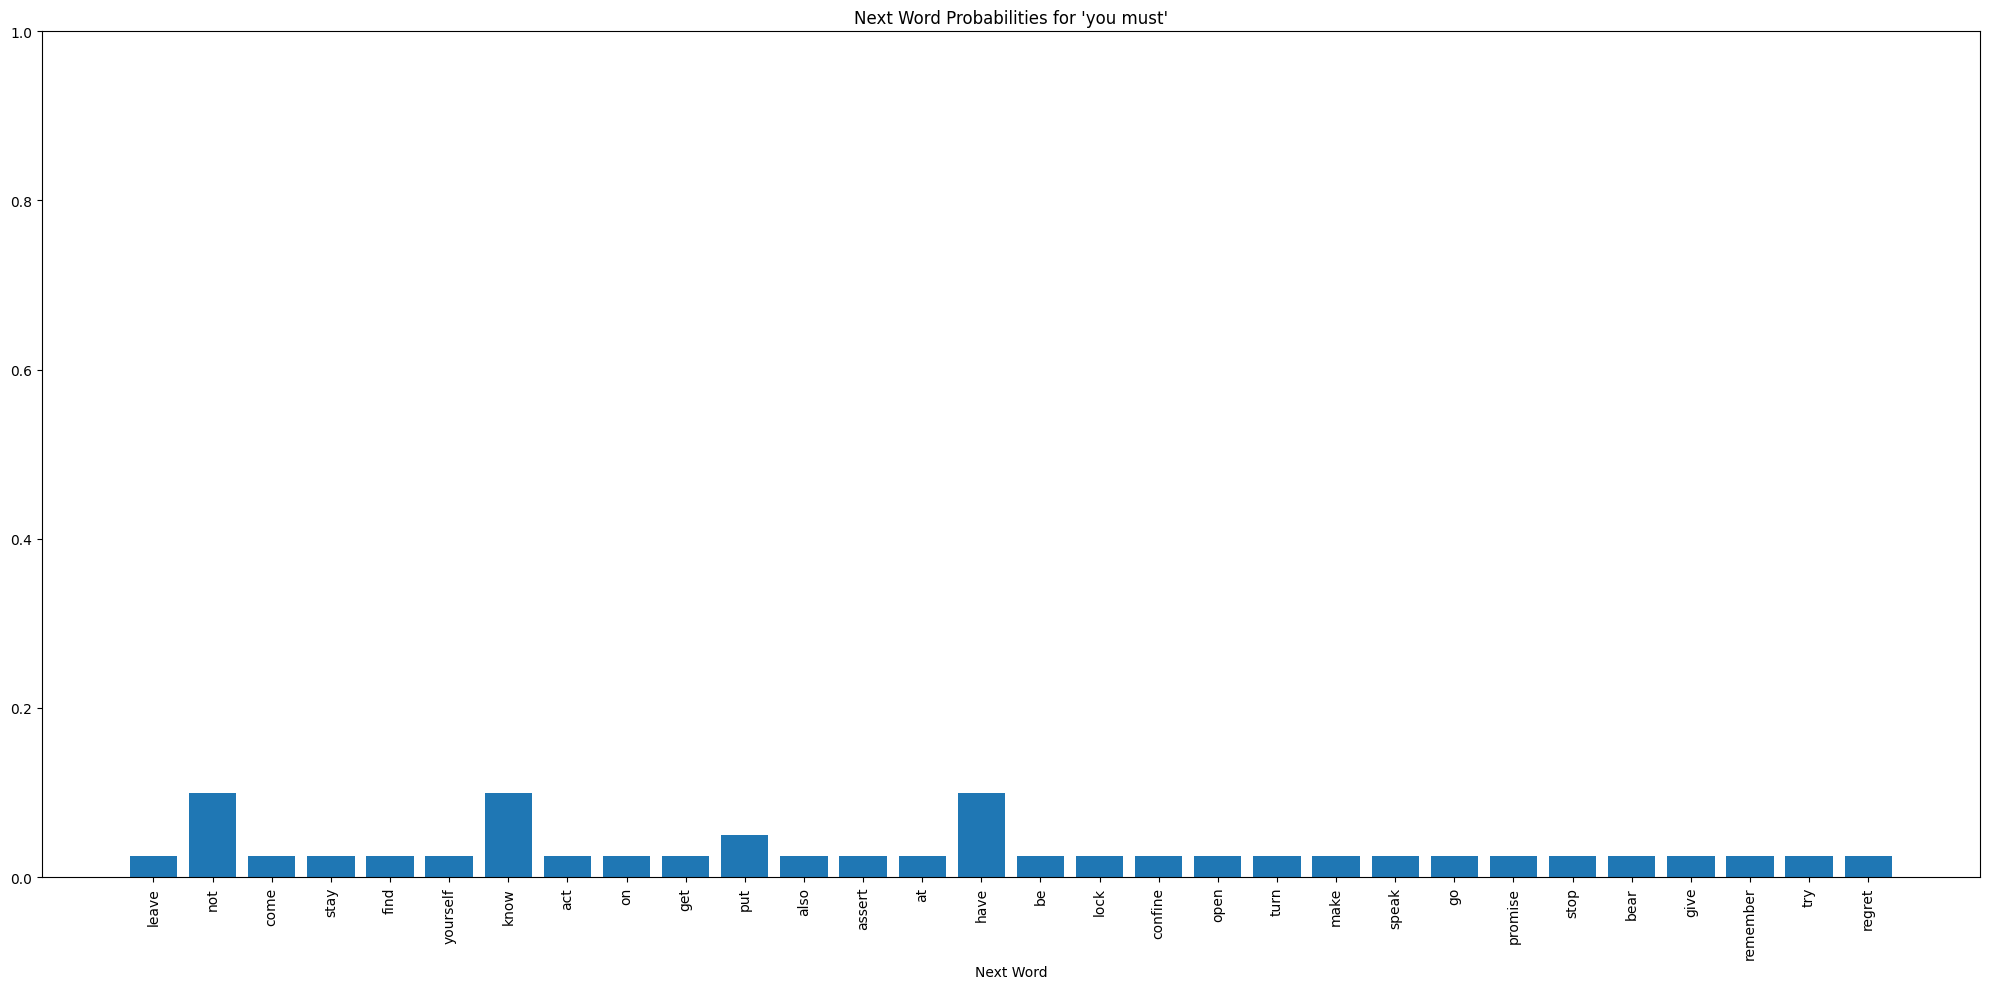

In [13]:
model.plot_next_word_probability("you must")

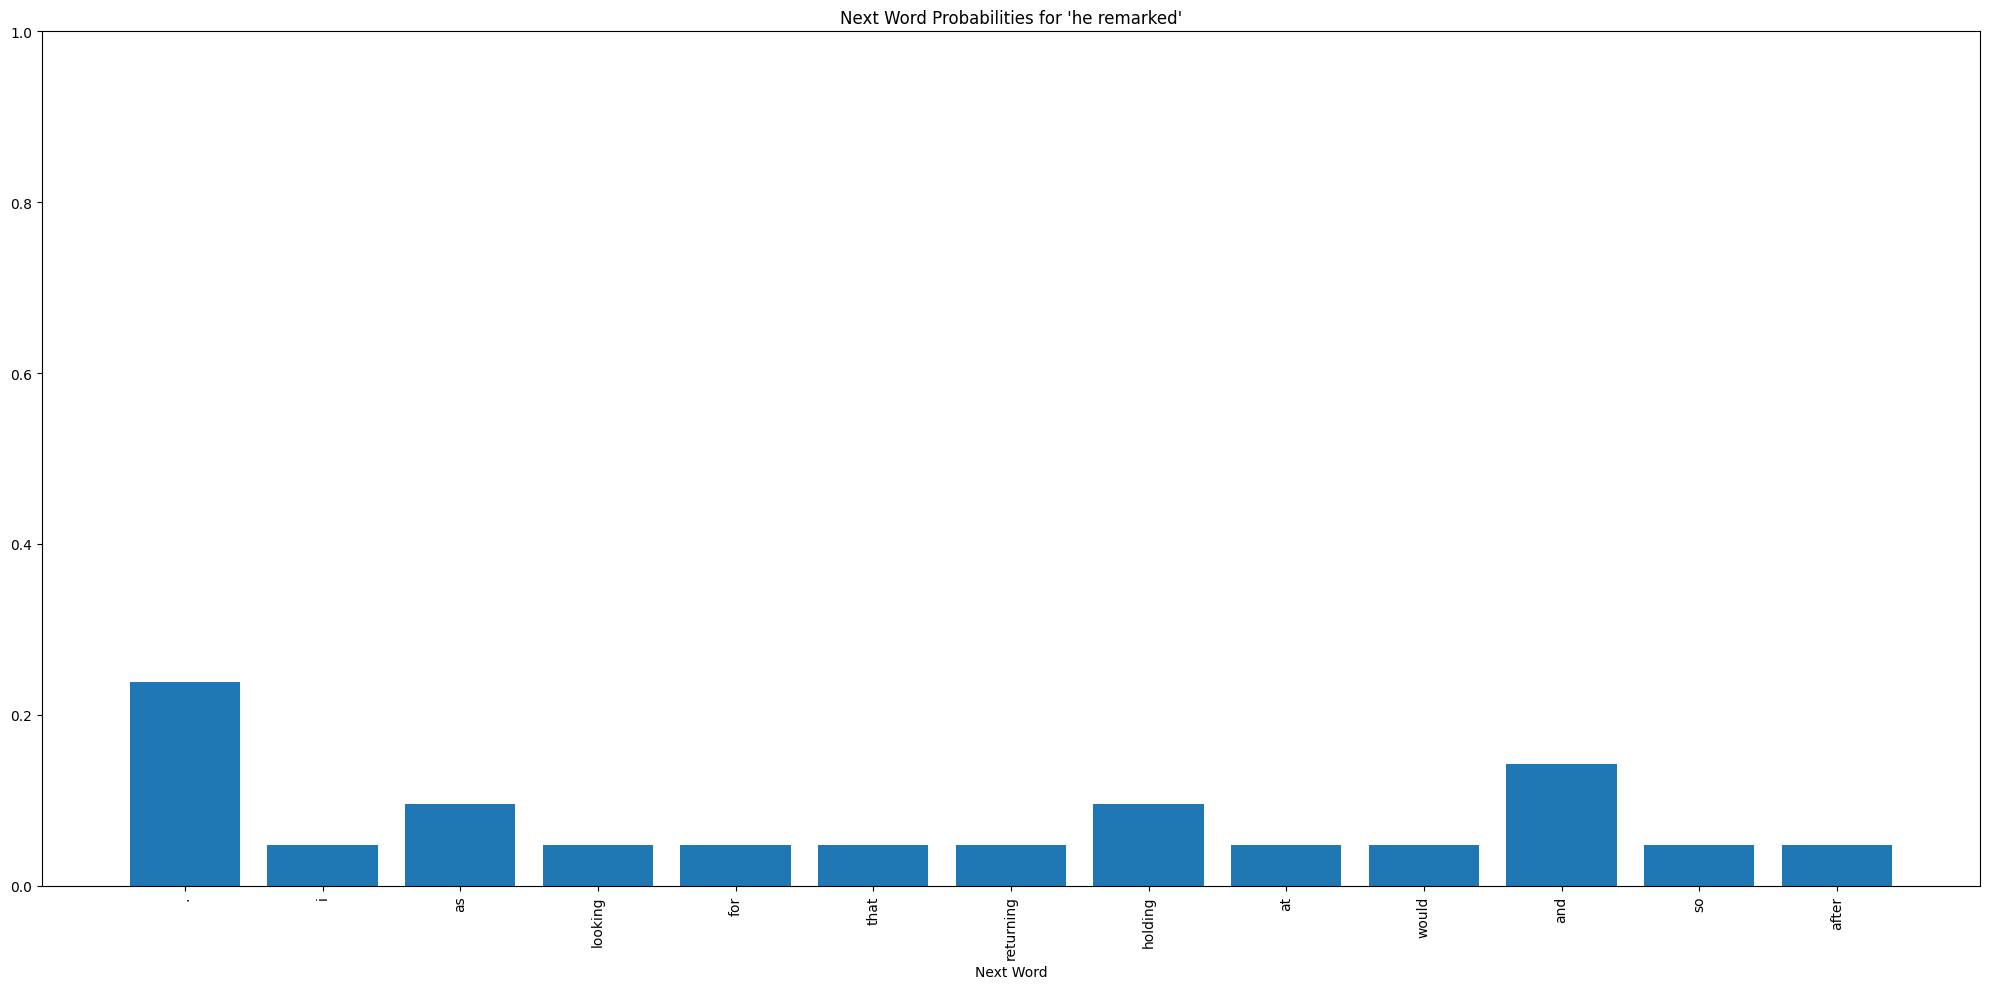

In [16]:
model.plot_next_word_probability("he remarked")